In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Link coordinates from notebook 4 to buildings

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import os, bz2
import numpy as np
import tilemapbase
import open_cp.geometry
open_cp.geometry.configure_gdal()
import open_cp.logger
open_cp.logger.log_to_true_stdout("opencrimedate")
import rtree

import opencrimedata.address
import opencrimedata.san_francisco
import opencrimedata.replace

proj = opencrimedata.san_francisco.projector()

### Load address database

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
filename = os.path.join(datadir, "openaddr-collected-us_west.zip")

In [4]:
address_match = opencrimedata.address.AddressMatch.from_zip(filename, "ca", "san_francisco", proj)

# First attempt at Redistribute

Assign to closest address.  Annoying left/right side of street issue results.

In [5]:
def gen():
    filename = os.path.join(datadir, "SF_Redist_3.csv.bz2")
    with bz2.open(filename, "rt") as f:
        yield from opencrimedata.san_francisco.load(f)

row = next(gen())
row, address_match.closest(proj(*row.point))

(Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(-122.42150458627911, 37.76093014121479), idd='15006027571000', incident='150060275'),
 (array(['751', 'VALENCIA ST'], 
        dtype='<U24'), array([ 1830732.10487709,   641671.53982754])))

In [6]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        address, pt = address_match.closest(proj(*row.point))
        return opencrimedata.san_francisco.row_with_new_position(row, *proj(*pt, inverse=True))
    
assign = AssignNew(gen(), seed=1234)
new_data = list(assign)

In [7]:
assign.input_hash, assign.output_hash

('f267f680812f7ff935a3ddd9d3e4bd3f0ffc6f46c27e306c0bf89532825e81ed',
 'faf050551bc1ca27d731cfb9f95a04ff217e30d3999a1bd98743f343bffd4003')

In [8]:
assign.input_size, assign.failed_to_reassign_count

(2119901, 0)

### Plots

In [9]:
def gen_old():
    filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)

new_points = {row.idd : row.point for row in new_data}
old_points = {row.idd : row.point for row in gen_old()}
mid_points = {row.idd : row.point for row in gen()}

In [10]:
pts_new, pts_mid, pts_old = [], [], []
for key in new_points:
    pts_new.append( tilemapbase.project(*new_points[key]) )
    pts_mid.append( tilemapbase.project(*mid_points[key]) )
    pts_old.append( tilemapbase.project(*old_points[key]) )
pts_new = np.asarray(pts_new)
pts_mid = np.asarray(pts_mid)
pts_old = np.asarray(pts_old)

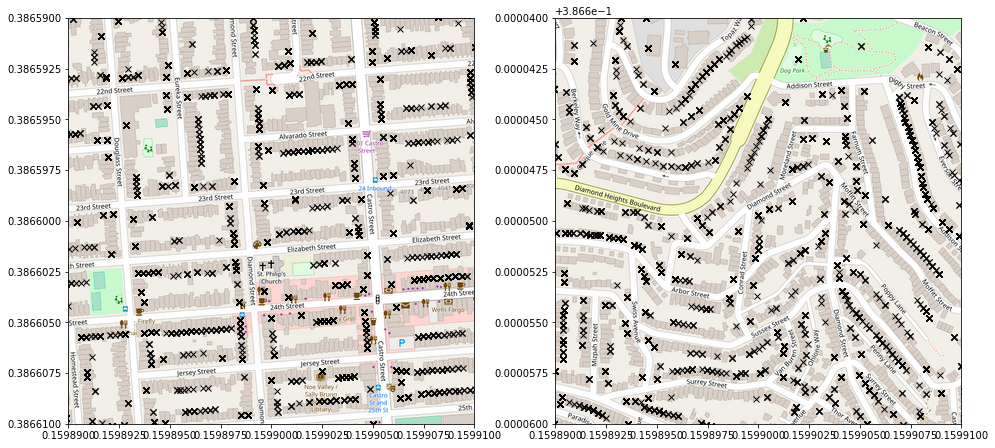

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1599, 0.3866, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.1599, 0.38665, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

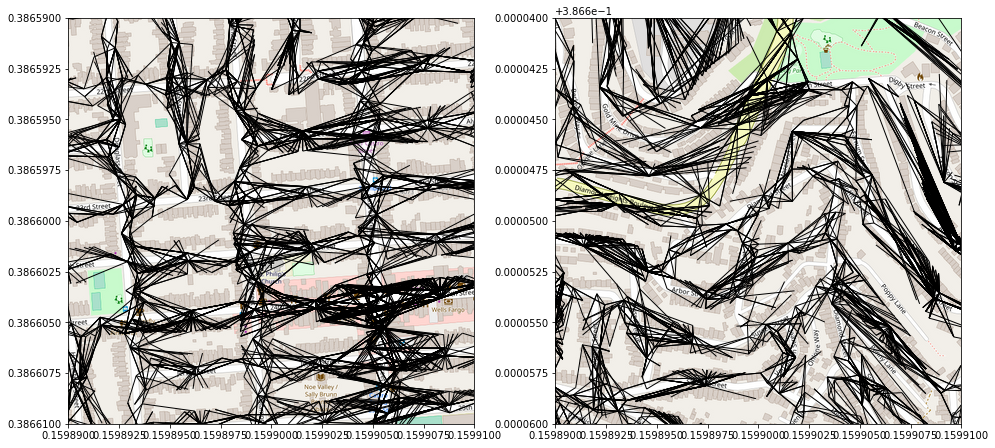

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1599, 0.3866, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.1599, 0.38665, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

for ax in axes:
    lines = list(zip(pts_new, pts_old))
    lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
    ax.add_collection(lines)

In [13]:
add_pts_wm = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in address_match.address_points])

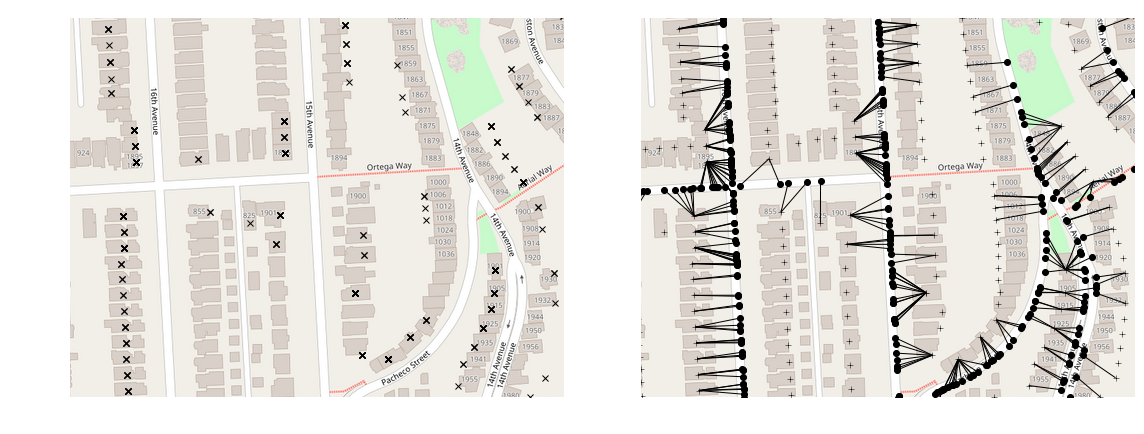

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

ax = axes[1]
plotter.plot(ax)
lines = list(zip(pts_new, pts_mid))
lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(lines)
ax.scatter(*add_pts_wm.T, marker="+", linewidth=0.5, color="black")
ax.scatter(*pts_mid.T, marker="o", color="black")

for ax in axes:
    ax.set_axis_off()

fig.tight_layout()

# Redistribution with randomness

Now choose anywhere, at random, within 75m of the point.

In [26]:
row = next(gen())
addresses, pts = address_match.all_in_disc(proj(*row.point), 30)
row, pts.shape, pts

(Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(-122.42150458627911, 37.76093014121479), idd='15006027571000', incident='150060275'),
 (16, 2),
 array([[ 1830678.89762129,   641680.80260273],
        [ 1830678.89762129,   641680.80260273],
        [ 1830678.89762129,   641680.80260273],
        [ 1830678.89762129,   641680.80260273],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830686.0905087 ,   641698.47157942],
        [ 1830732.10487709,   641671.53982754],
        [ 1830679.73963831,   641665.58838184],
        [ 1830679.73963831,   641665.58

In [27]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        d = 75
        while True:
            addresses, pts = address_match.all_in_disc(proj(*row.point), d)
            if len(pts) == 0:
                d += d
                if d > 1000:
                    raise ValueError()
            else:
                break
        i = np.random.randint(0, pts.shape[0])
        pt = pts[i]
        return opencrimedata.san_francisco.row_with_new_position(row, *proj(*pt, inverse=True))
    
assign = AssignNew(gen(), seed=1234)
with bz2.open(os.path.join(datadir, "SF_Redist_4.csv.bz2"), "wt", newline="") as f:
    opencrimedata.san_francisco.write(f, assign)

In [28]:
assign.input_hash, assign.output_hash

('f267f680812f7ff935a3ddd9d3e4bd3f0ffc6f46c27e306c0bf89532825e81ed',
 '138c6818142b8771e63a5719ce9ec064e43f9ea2bc273529a283953e8da123c9')

In [29]:
assign.input_size, assign.failed_to_reassign_count

(2119901, 0)

## Plots

In [4]:
def gen():
    filename = os.path.join(datadir, "SF_Redist_3.csv.bz2")
    with bz2.open(filename, "rt") as f:
        yield from opencrimedata.san_francisco.load(f)

def gen_old():
    filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)
        
def gen_new():
    filename = os.path.join(datadir, "SF_Redist_4.csv.bz2")
    with bz2.open(filename, "rt") as f:
        yield from opencrimedata.san_francisco.load(f)
        
old_points = {row.idd : row.point for row in gen_old()}
new_points = {row.idd : row.point for row in gen_new()}
mid_points = {row.idd : row.point for row in gen()}

In [5]:
pts_new, pts_mid, pts_old = [], [], []
for key in new_points:
    pts_new.append( tilemapbase.project(*new_points[key]) )
    pts_mid.append( tilemapbase.project(*mid_points[key]) )
    pts_old.append( tilemapbase.project(*old_points[key]) )
pts_new = np.asarray(pts_new)
pts_mid = np.asarray(pts_mid)
pts_old = np.asarray(pts_old)

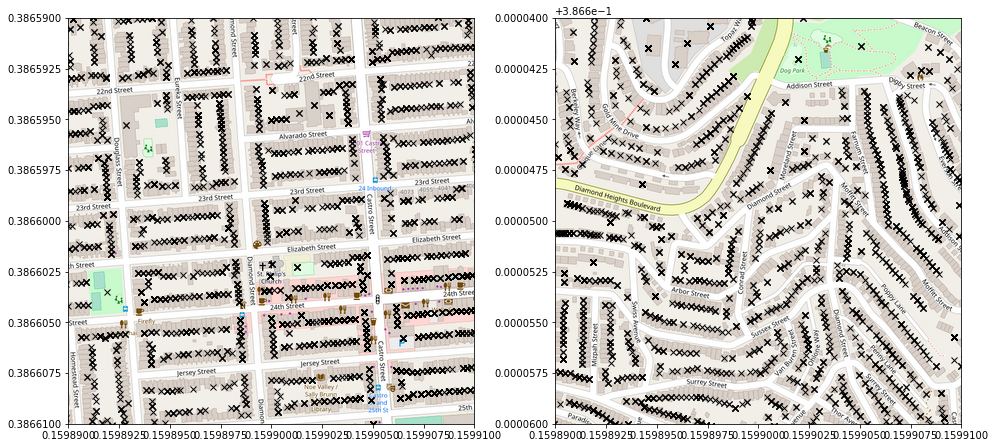

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1599, 0.3866, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.1599, 0.38665, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

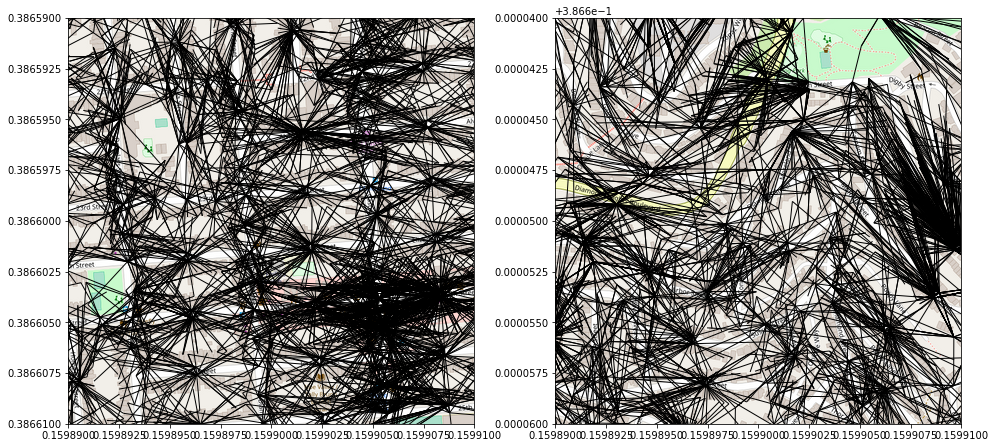

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1599, 0.3866, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.1599, 0.38665, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

for ax in axes:
    lines = list(zip(pts_new, pts_old))
    lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
    ax.add_collection(lines)

In [10]:
add_pts_wm = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in address_match.address_points])

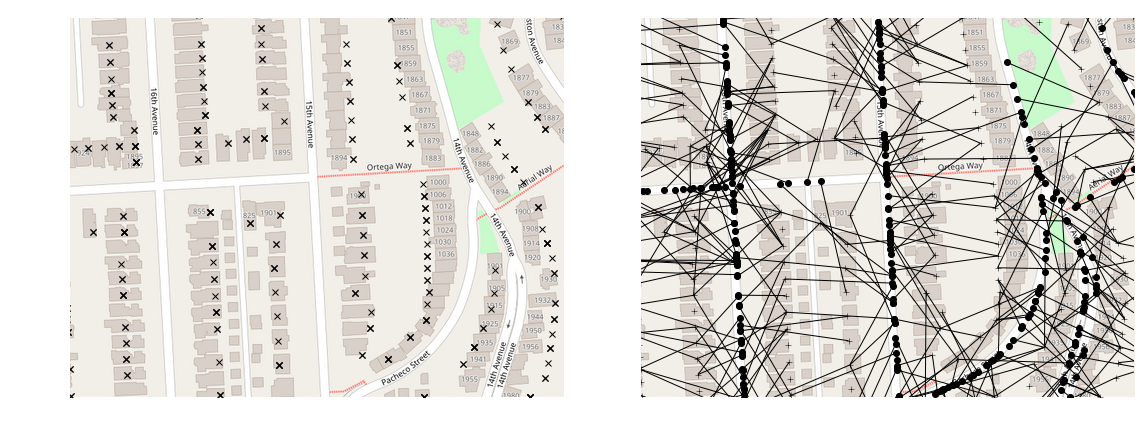

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

ax = axes[1]
plotter.plot(ax)
lines = list(zip(pts_new, pts_mid))
lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(lines)
ax.scatter(*add_pts_wm.T, marker="+", linewidth=0.5, color="black")
ax.scatter(*pts_mid.T, marker="o", color="black")

for ax in axes:
    ax.set_axis_off()

fig.tight_layout()

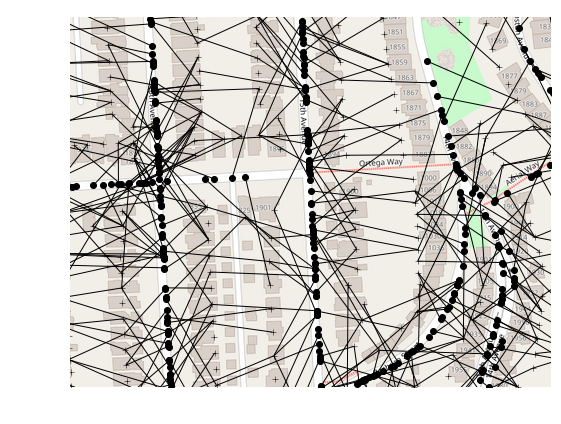

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

plotter.plot(ax)
lines = list(zip(pts_new, pts_mid))
lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(lines)
ax.scatter(*add_pts_wm.T, marker="+", linewidth=0.5, color="black")
ax.scatter(*pts_mid.T, marker="o", color="black")
ax.set_axis_off()
fig.tight_layout()

In [13]:
fig.savefig("sf_flow_to_buildings_1.png", dpi=150)

# Redistribute using the street network

Project the _building_ points to the nearest street, and then work just on the street network.

### Load street data

And paranoid check projecting does very little

In [9]:
def gen_streets():
    filename = os.path.join(datadir, "San Francisco Basemap Street Centerlines")
    for row in opencrimedata.san_francisco.load_street_centre_lines(filename):
        if opencrimedata.san_francisco.street_layer_accept(row):
            yield row
            
proj = opencrimedata.san_francisco.projector()

def proj_street(street):
    line = np.asarray(street.line)
    return np.asarray(proj(*line.T)).T

graph, graph_names = opencrimedata.geometry.graph_from_streets(gen_streets(), proj_street)

In [10]:
for row in gen():
    x, y = proj(*row.point)
    edge, t = graph.project_point_to_graph(x, y)
    xx, yy = graph.edge_to_coords(*edge, t)
    assert (x-xx)**2 + (y-yy)**2 < 1e-14

### Project buildings to street network

In [11]:
addresses_on_network = []
for pt in address_match.address_points:
    edge, t = graph.project_point_to_graph(*pt)
    addresses_on_network.append(graph.edge_to_coords(*edge, t))
addresses_on_network = np.asarray(addresses_on_network)

In [12]:
matcher = opencrimedata.geometry.ClosestPoint(addresses_on_network)

In [13]:
row = next(iter(gen()))
idxes, points = matcher.all_in_disc(proj(*row.point), 10)

In [14]:
row, address_match.addresses[idxes]

(Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(-122.42150458627911, 37.76093014121479), idd='15006027571000', incident='150060275'),
 array([['751', 'VALENCIA ST'],
        ['739', 'VALENCIA ST'],
        ['741', 'VALENCIA ST'],
        ['748', 'VALENCIA ST'],
        ['740', 'VALENCIA ST'],
        ['742', 'VALENCIA ST'],
        ['746', 'VALENCIA ST']], 
       dtype='<U24'))

In [15]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        pt = proj(*row.point)
        d = 10
        while True:
            indicies, _ = matcher.all_in_disc(pt, d)
            if len(indicies) == 0:
                d += 10
            else:
                break
        i = np.random.choice(indicies)
        pt = address_match.address_points[i]
        return opencrimedata.san_francisco.row_with_new_position(row, *proj(*pt, inverse=True))
    
assign = AssignNew(gen(), seed=1234)
with bz2.open(os.path.join(datadir, "SF_Redist_4a.csv.bz2"), "wt", newline="") as f:
    opencrimedata.san_francisco.write(f, assign)

## Plots

In [15]:
def gen_old():
    filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)
        
def gen_new():
    filename = os.path.join(datadir, "SF_Redist_4a.csv.bz2")
    with bz2.open(filename, "rt") as f:
        yield from opencrimedata.san_francisco.load(f)
        
old_points = {row.idd : row.point for row in gen_old()}
new_points = {row.idd : row.point for row in gen_new()}
mid_points = {row.idd : row.point for row in gen()}

In [16]:
pts_new, pts_mid, pts_old = [], [], []
for key in new_points:
    pts_new.append( tilemapbase.project(*new_points[key]) )
    pts_mid.append( tilemapbase.project(*mid_points[key]) )
    pts_old.append( tilemapbase.project(*old_points[key]) )
pts_new = np.asarray(pts_new)
pts_mid = np.asarray(pts_mid)
pts_old = np.asarray(pts_old)

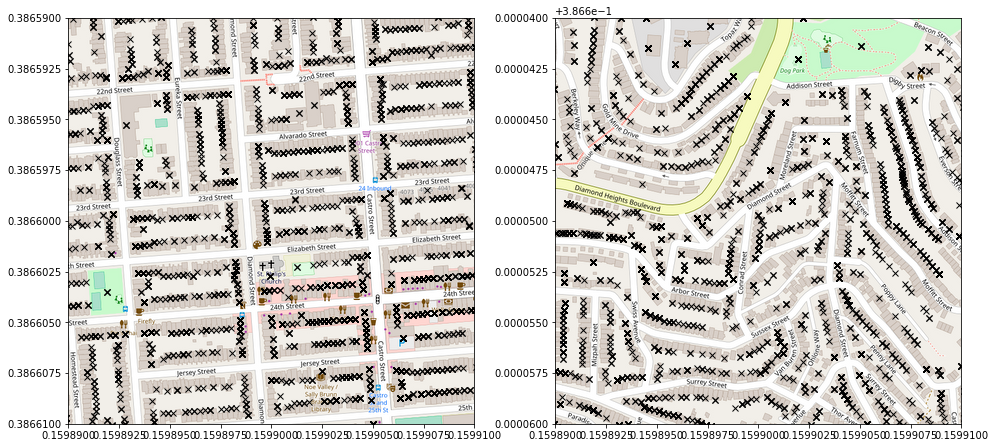

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1599, 0.3866, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.1599, 0.38665, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

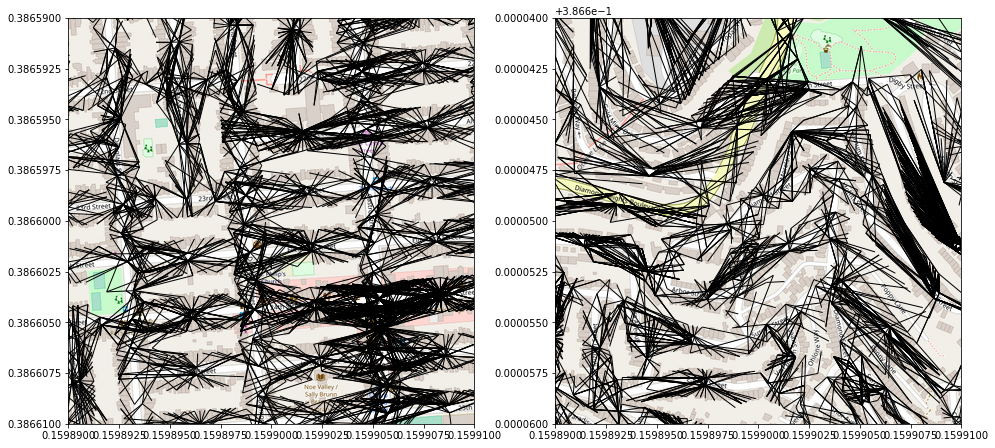

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1599, 0.3866, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.1599, 0.38665, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)

for ax in axes:
    lines = list(zip(pts_new, pts_old))
    lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
    ax.add_collection(lines)

In [19]:
add_pts_wm = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in address_match.address_points])

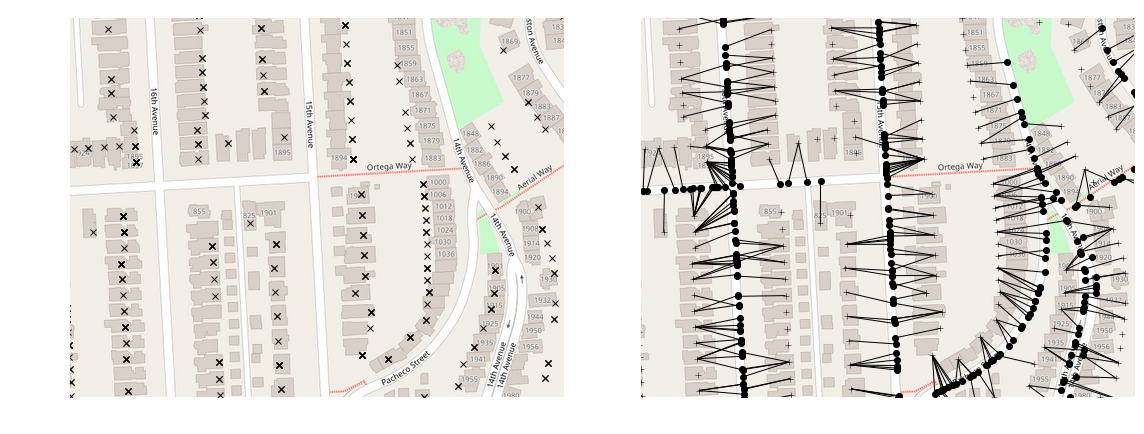

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.1598, 0.3866, xsize=0.00001, aspect=1.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*pts_new.T, marker="x", color="black", linewidth=1)

ax = axes[1]
plotter.plot(ax)
lines = list(zip(pts_new, pts_mid))
lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(lines)
ax.scatter(*add_pts_wm.T, marker="+", linewidth=0.5, color="black")
ax.scatter(*pts_mid.T, marker="o", color="black")

for ax in axes:
    ax.set_axis_off()

fig.tight_layout()

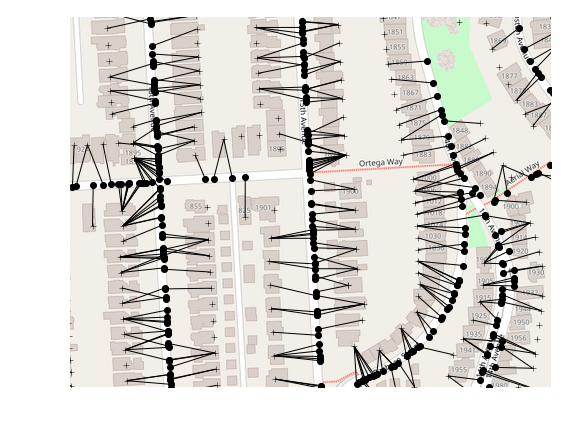

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

plotter.plot(ax)
lines = list(zip(pts_new, pts_mid))
lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(lines)
ax.scatter(*add_pts_wm.T, marker="+", linewidth=0.5, color="black")
ax.scatter(*pts_mid.T, marker="o", color="black")
ax.set_axis_off()
fig.tight_layout()

In [22]:
fig.savefig("sf_flow_to_buildings_2.png", dpi=150)